# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


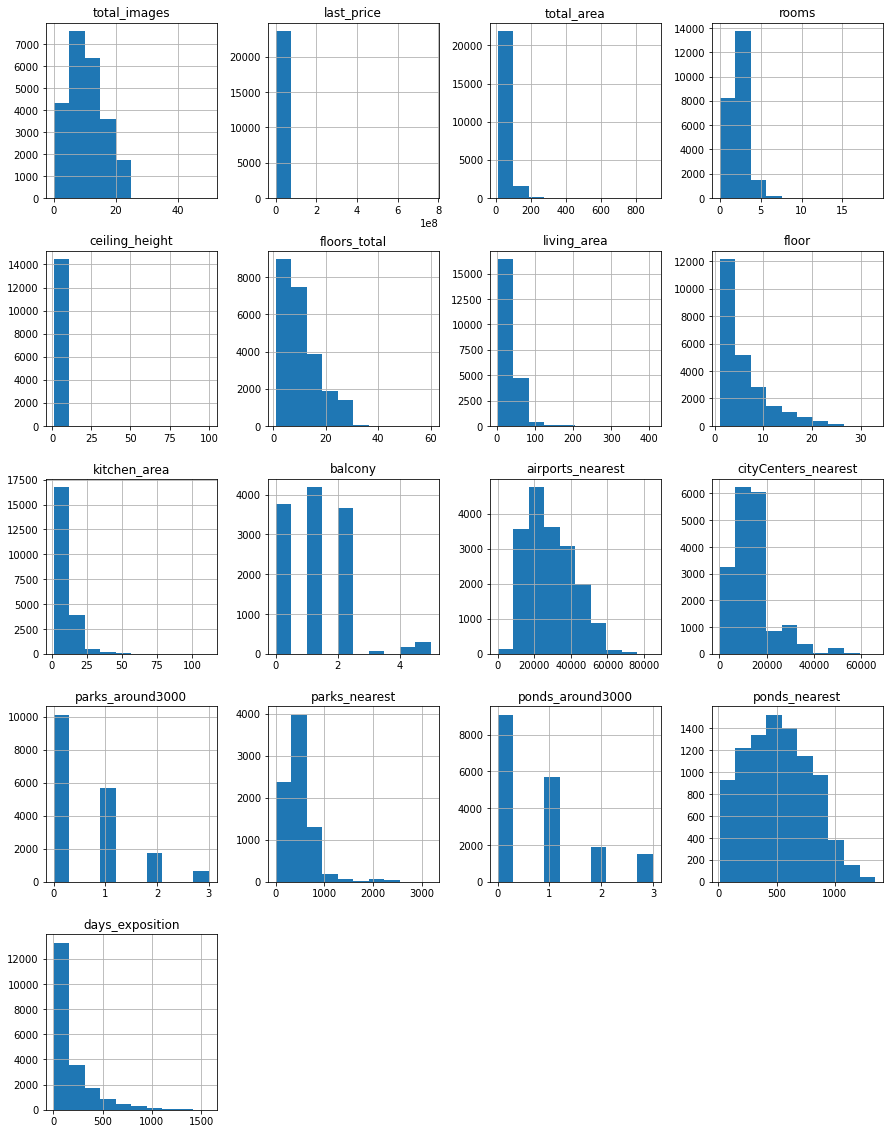

In [2]:
data.info()
display(data.head())
data.hist(figsize=(15, 20));

### Предобработка данных

In [3]:
#Название колонки cityCenters_nearest не соответствует хорошему стилю:
data = data.rename(columns={ 'cityCenters_nearest': 'city_centers_nearest' })

#### Явные дубликаты

In [4]:
print('Количество явных дубликатов:', data.duplicated().sum())
data = data.drop_duplicates()

Количество явных дубликатов: 0


#### Пропуски

Наблюдается множество пропущенных значений в разных колонках:
* **ceiling_height** - можно заменить на медиану.  По гистограмме видно, что есть потолки до 100 метров. Поэтому, для начала, нужно разобраться с экстремумами.
* **floors_total** - таких записей всего 86. Можно проигнорировать - тогда они просто не попадут в анализ по последнему этажу.
* **living_area** - можно проигнорировать эти строки. В теории, можно было бы посчитать что-нибудь в духе медианы процента жилой площади в квартире. Но это может исказить результат.
* **kitchen_area** - тоже игнорируем.
* **is_apartment** - конвертировать в False.
* **balcony** - конвертировать в 0.
* **days_exposition** - тут не понятно. Пустота в этом поле может означать разное: квартира еще не продана, объявление сразу сняли (публикация по ошибке), квартиру сразу выкупили. Из-за неоднозначности, эти строки стоит убрать из анализа
* **locality_name** - конвертировать в "Другое". Локация для анализа не критична.
* **parks_around3000, ponds_around3000** - можно предположить, что null означает просто, что поблизости нет соответствующих объектов - тогда можно заменить на 0.
* Также, среди картографических данных геолокации много пустых значний. Похоже, между ними есть связь.

##### Пропуски в картографических данных

In [5]:
geo_nearest_columns = ['airports_nearest', 'city_centers_nearest', 'parks_nearest', 'ponds_nearest']

#Анализ пустот в данных геолокации:
empty_parks = data['parks_around3000'].isna()
empty_ponds = data['ponds_around3000'].isna()

#эти запросы покажут, что количество пропущенных parks_around3000 равно ponds_around3000:
print('empty parks:', data[empty_parks]['total_images'].count())
print('empty ponds:', data[empty_ponds]['total_images'].count())

#этот запрос покажет, что parks_around3000 и ponds_around3000 пусты в одних и тех же строках.
#также в этих строках пусты все данные геолокации
print(data[empty_parks][[
    'ponds_around3000', 
    'parks_around3000',
    'airports_nearest',
    'city_centers_nearest',
    'parks_nearest',
    'ponds_nearest'
]].count())

#этот запрос покажет, что колонки *nearest пусты только когда нет данных геолокации,
#либо когда поблизости нет соответствующих объектов
print(data[data['ponds_nearest'].isna()]['ponds_around3000'].unique())
print(data[data['parks_nearest'].isna()]['parks_around3000'].unique())

empty parks: 5518
empty ponds: 5518
ponds_around3000        0
parks_around3000        0
airports_nearest        0
city_centers_nearest    0
parks_nearest           0
ponds_nearest           0
dtype: int64
[ 0. nan]
[ 0. nan]


Несколько выводов по колонкам, полученным из картографических данных:
* Для некоторых объявлений не были получены данные геолокации. Могут быть разные причины, почему это произошло (некорректный адрес, ошибка в запросе на выборку, ошибка ПО). Такие строки, в теории, можно заполнить медианами в разрезе названия локации. Но безопасней вообще не заполнять - тогда они никак не повлияют на графики.
* "nearest" поля пустые в двух случаях: если нет данных геолокации (и тогда их следуют оставить пустыми) и если поблизости нет соответствующих объектов (и тогда их можно заполнить максимальным значением своей колонки)

In [6]:
for column in geo_nearest_columns:
    data.loc[(data[column].isna()) & (data['ponds_around3000'].notnull()), column] = data[column].max()

##### Корректировка высоких потолков

In [7]:
data.query('ceiling_height > 20').sort_values('ceiling_height', ascending=False).head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
22869,0,15000000.0,25.0,2018-07-25T00:00:00,1,100.0,5.0,14.0,5,True,...,11.0,5.0,Санкт-Петербург,34963.0,8283.0,1.0,223.0,3.0,30.0,19.0
22336,19,9999000.0,92.4,2019-04-05T00:00:00,2,32.0,6.0,55.5,5,False,...,16.5,4.0,Санкт-Петербург,18838.0,3506.0,0.0,3190.0,3.0,511.0,NaN
3148,14,2900000.0,75.0,2018-11-12T00:00:00,3,32.0,3.0,53.0,2,NaN,...,8.0,NaN,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21377,19,4900000.0,42.0,2017-04-18T00:00:00,1,27.5,24.0,37.7,19,False,...,11.0,2.0,Санкт-Петербург,42742.0,9760.0,0.0,3190.0,0.0,1344.0,61.0
22938,14,4000000.0,98.0,2018-03-15T00:00:00,4,27.0,2.0,73.0,2,True,...,9.0,1.0,деревня Нижняя,NaN,NaN,NaN,NaN,NaN,NaN,27.0


* Объявление со 100-метровым потолком подозрительно нереалистичное. Без фото, 25 квадратов и целых 5 балконов. Стоит его вообще убрать из выборки. 
* Остальные высоты потолков гораздо меньше. А в двухзначных значениях, возможно, пропущен десятичный разделитель. Исправить это можно просто поделив такие высоты на 10.

In [8]:
data = data.query('ceiling_height != 100')
def fix_ceiling_height(value):
    if value >= 20:
        return value / 10
    return value

data['ceiling_height'] = data['ceiling_height'].apply(fix_ceiling_height)

##### Пропуски и конвертация

In [9]:
data = data.fillna({
    'balcony': 0,
    'is_apartment': False,
    'locality_name': 'Другое',
    'ceiling_height': data['ceiling_height'].median()    
})

Необходимо конвертировать часть колонок в более подходящие типы:
* **first_day_exposition** в формат даты (во-первых, в колонке реально дата, во-вторых - с форматом даты будет проще вести дальнейшие вычисления и анализ).
* **balcony** должны быть целыми числами. 

In [10]:
data['balcony'] = data['balcony'].astype(int)
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

##### Неявные дубликаты в locality_name

In [11]:
print(len(data['locality_name'].unique()))
print(data['locality_name'].unique()[:20])

365
['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино']


In [12]:
#Много названий. Можно убрать приставки - тогда наименований должно стать меньше.
prefixes = [
    'садоводческое некоммерческое товарищество', 
    'деревня',
    'городской',
    'коттеджный',
    'посёлок',
    'поселок',
    'садовое товарищество',
    'городского типа',
    'при железнодорожной станции',
    'село',
    'станции',
    'имени'
]
def simplify_localities(locality_name):
    for prefix in prefixes:
        locality_name = locality_name.replace(prefix, '').strip()
    return locality_name

data['short_locality_name'] = data['locality_name'].apply(simplify_localities)
len(data['short_locality_name'].unique())

306

##### Аномалии

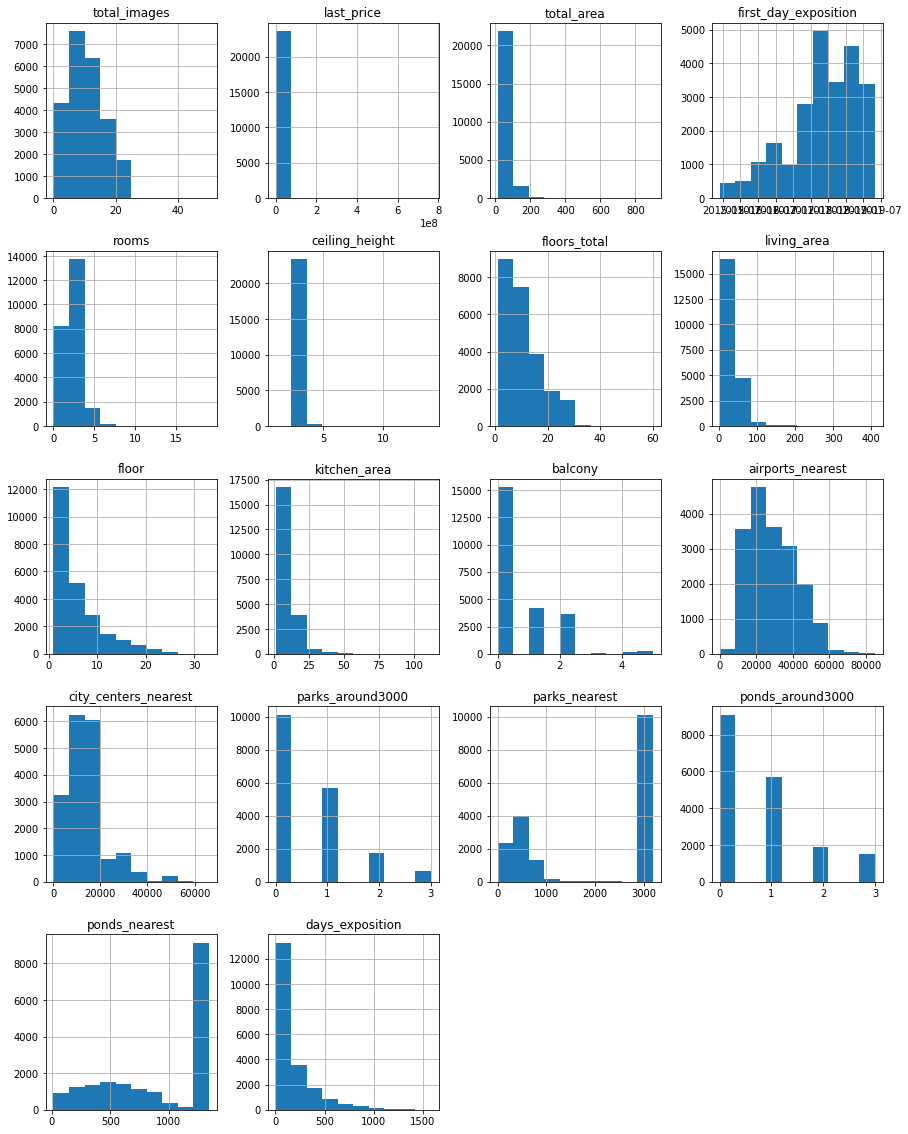

In [13]:
data.hist(figsize=(15, 20));

После предобратки по гистограммам видно, что есть выбивающиеся значения для last_price, total_area,rooms, ceiling_height, living_area, kitchen_area. Также есть всплески в parks_nearest и ponds_nearest - это пропущенные заначения, которые ранее были заполненны максимумаи. По сути они позволяют сказать, что большинство объектов находится далеко от парков и прудов. 

In [14]:
import matplotlib.pyplot as plt
data[['last_price', 'total_area', 'rooms', 'ceiling_height', 'living_area', 'kitchen_area']].describe()

,last_price,total_area,rooms,ceiling_height,living_area,kitchen_area
count,2.369800e+04,23698.000000,23698.000000,23698.000000,21795.000000,21420.000000
mean,6.541192e+06,60.350143,2.070681,2.698413,34.458791,10.569787
std,1.088710e+07,35.654096,1.078405,0.248731,22.030515,5.905575
min,1.219000e+04,12.000000,0.000000,1.000000,2.000000,1.300000
25%,3.400000e+06,40.000000,1.000000,2.600000,18.600000,7.000000
50%,4.650000e+06,52.000000,2.000000,2.650000,30.000000,9.100000
75%,6.799750e+06,69.900000,3.000000,2.700000,42.300000,12.000000
max,7.630000e+08,900.000000,19.000000,14.000000,409.700000,112.000000


Похоже, из общего ряда выбивается элитная недвижимость. Возможно, даже, нежилая. На это указывают и цены > 100 млн., и площади под тысячу кв.м. Такая недвижимость существует по своим законам и не имеет смысла использовать ее при анализе влияния на цену среднюю:

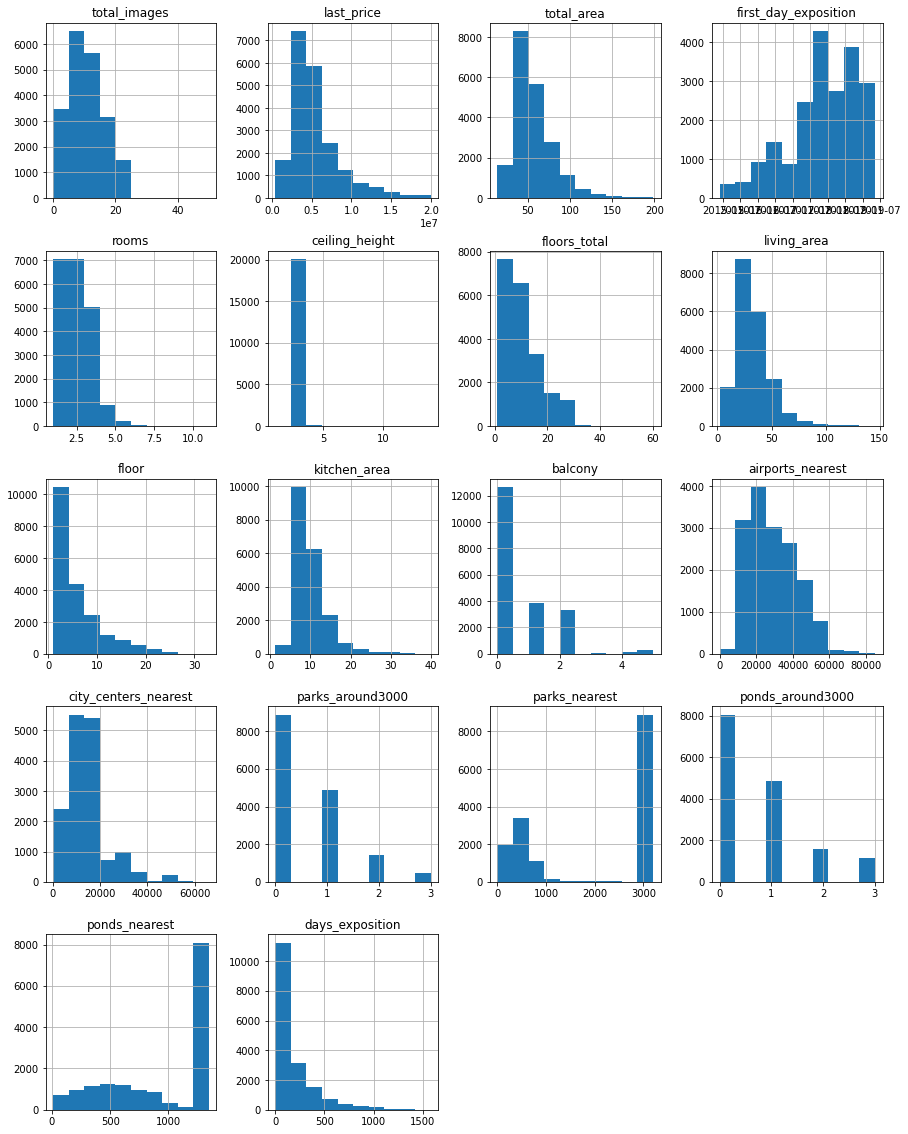

In [15]:
data = data.query(
    '(last_price <= 20000000) and (total_area < 200) and (living_area < 150) and (kitchen_area < 40)'
)

data.hist(figsize=(15, 20));

#### Вывод по предобработке

* Существует явная проблема с привязкой картографических данных.
* Не ясно, что понимается под 'nearest' в колонках airports_nearest, city_centers_nearest, parks_nearest, ponds_nearest. Из-за этого их предобработка могла быть выполнена некорректно.
* Определенные сложности создает остутсвие контроля вводимых значений.
* Неконсистентный справочник населенных пунктов.

### Посчитайте и добавьте в таблицу новые столбцы

In [16]:
import numpy
def get_floor_kind(row):
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == row['floors_total']:
        return 'последний'
    return 'другой'

data['price_per_meter'] = data['last_price'] / data['total_area']
data['publication_week_day'] = data['first_day_exposition'].dt.dayofweek
data['publication_month'] = data['first_day_exposition'].dt.month
data['publication_year'] = data['first_day_exposition'].dt.year
data['floor_kind'] = data.apply(get_floor_kind, axis=1)
data['km_to_center'] = numpy.floor(data['city_centers_nearest'] / 1000)

### Проведите исследовательский анализ данных

##### Цена объектов

count    2.029200e+04
mean     5.426563e+06
std      3.121956e+06
min      4.300000e+05
25%      3.450000e+06
50%      4.600000e+06
75%      6.500000e+06
max      2.000000e+07
Name: last_price, dtype: float64


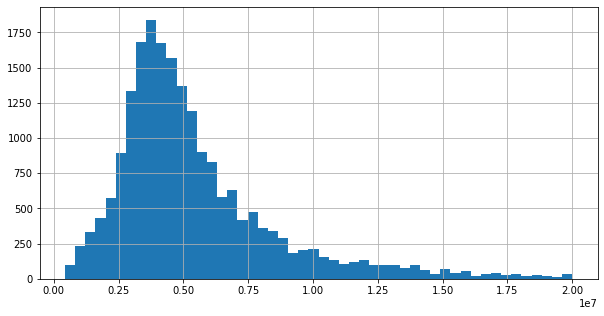

In [17]:
print(data['last_price'].describe())
data['last_price'].hist(figsize=(10,5), bins=50);

Похоже на нормальное распределение. Цены, обычно, не превышают 10 млн. Есть выбросы до 20 млн., но они не кажутся фантастическими.

##### Площади

,total_area,living_area,kitchen_area
count,20292.000000,20292.000000,20292.000000
mean,56.693005,32.508623,9.962765
std,23.073263,15.901442,4.246277
min,14.000000,2.000000,1.300000
25%,40.000000,18.600000,7.000000
50%,51.200000,30.000000,9.000000
75%,67.200000,41.500000,11.470000
max,198.100000,145.400000,39.900000


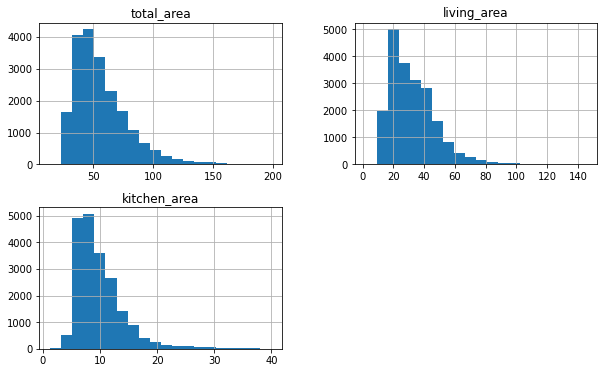

In [18]:
display(data[['total_area', 'living_area', 'kitchen_area']].describe())
data.hist(figsize=(10,6), column=[
    'total_area',
    'living_area',
    'kitchen_area'
], bins=20);

Половина продаваемой недвижимости не превышает 51 кв.м. Люди часто берут маленькие квартиры для сдачи и в качестве инвестиций. 

По данным выходит, что площадь обычно не превышает 100 кв.м., хотя есть и выбросы до 200 квадратов. Но такие цифры тоже кажутся реальными. 

##### Комнаты

count    20292.000000
mean         2.028583
std          0.954575
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         11.000000
Name: rooms, dtype: float64


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,short_locality_name,price_per_meter,publication_week_day,publication_month,publication_year,floor_kind,km_to_center
648,3,17500000.0,183.7,2018-07-01,11,3.40,7.0,138.8,7,False,...,0.0,1344.0,NaN,Санкт-Петербург,95264.017420,6,7,2018,последний,3.0
8758,5,16100000.0,150.0,2018-07-10,8,2.92,5.0,107.0,1,False,...,0.0,1344.0,NaN,Санкт-Петербург,107333.333333,1,7,2018,первый,4.0
855,18,15000000.0,134.0,2017-10-27,7,2.65,4.0,88.0,3,False,...,1.0,387.0,150.0,Санкт-Петербург,111940.298507,4,10,2017,другой,3.0
1813,0,15000000.0,179.0,2017-04-09,7,2.65,5.0,126.4,5,False,...,1.0,803.0,15.0,Санкт-Петербург,83798.882682,6,4,2017,последний,3.0
1943,20,16000000.0,184.4,2018-10-21,7,2.65,6.0,125.7,5,False,...,1.0,791.0,109.0,Санкт-Петербург,86767.895879,6,10,2018,другой,2.0


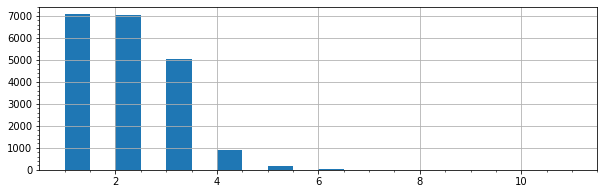

In [19]:
print(data['rooms'].describe())
display(data.query('rooms > 6').sort_values('rooms', ascending=False).head())
data['rooms'].hist(figsize=(10,3), bins=20).minorticks_on();

В основном, продаются 1-3 комнатные квартиры. Причем, количество однокомнатных и двухкомнатных равно. Похоже, это те самые квартиры до 50 кв.м. 

Есть несколько аномалий с количеством комнат больше 6. Но, если посмотреть на данные этих аномалий, то можно увидеть, например, 11 комнат на 180 кв.м. Это похоже на ошибки, допущенные при вводе данных.

##### Потолки

count    20292.000000
mean         2.687089
std          0.228040
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         14.000000
Name: ceiling_height, dtype: float64


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,short_locality_name,price_per_meter,publication_week_day,publication_month,publication_year,floor_kind,km_to_center
22590,16,6000000.0,55.0,2018-10-31,2,1.00,12.0,32.4,7,False,...,2.0,289.0,13.0,Санкт-Петербург,109090.909091,2,10,2018,другой,14.0
5712,5,1500000.0,42.8,2017-08-14,2,1.20,2.0,27.5,1,False,...,NaN,NaN,248.0,Мга,35046.728972,0,8,2017,первый,NaN
16934,5,4100000.0,40.0,2017-10-17,1,1.75,37.0,17.4,5,False,...,3.0,80.0,71.0,Санкт-Петербург,102500.000000,1,10,2017,другой,20.0
3474,3,1400000.0,30.0,2018-03-16,1,8.00,5.0,15.3,2,False,...,NaN,NaN,125.0,Нурма,46666.666667,4,3,2018,другой,NaN
15743,14,5600000.0,67.0,2016-11-11,3,8.00,16.0,41.0,1,False,...,0.0,1344.0,474.0,Санкт-Петербург,83582.089552,4,11,2016,первый,11.0
5863,20,5650000.0,45.0,2018-08-15,1,8.30,16.0,19.3,14,False,...,1.0,613.0,14.0,Санкт-Петербург,125555.555556,2,8,2018,другой,10.0
15061,19,5600000.0,56.4,2018-05-11,2,14.00,14.0,32.4,5,False,...,0.0,1344.0,315.0,Санкт-Петербург,99290.780142,4,5,2018,другой,13.0


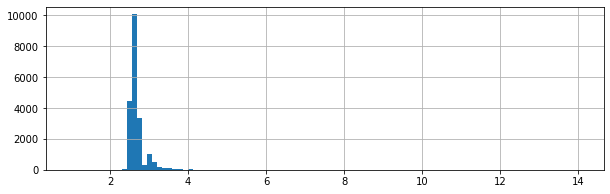

In [20]:
print(data['ceiling_height'].describe())
display(data.query('ceiling_height >= 5 or ceiling_height < 2').sort_values('ceiling_height'))
data['ceiling_height'].hist(figsize=(10,3), bins=100);

Высота потолков почти константа в районе 2.6-4 метров. Есть потолки и выше, но это можно списать на ошибки ввода или нежилую недвижимость.

14-метровый потолок только один. Судя по данным, он совпадает с номером этажа. Похоже, ввод одного значения в поле для другого значения является одним из источников некорректных данных.

Есть несколько выбросов и меньше 2м - тоже ошибка ввода.

##### Этажи

,floor,floors_total
count,20292.000000,20256.000000
mean,5.851025,10.626728
std,4.839001,6.553355
min,1.000000,1.000000
25%,2.000000,5.000000
50%,4.000000,9.000000
75%,8.000000,15.000000
max,33.000000,60.000000


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,short_locality_name,price_per_meter,publication_week_day,publication_month,publication_year,floor_kind,km_to_center
2253,12,3800000.0,45.5,2018-06-28,2,2.88,60.0,27.4,4,False,...,3.0,614.0,166.0,Кронштадт,83516.483516,3,6,2018,другой,49.0
16731,9,3978000.0,40.0,2018-09-24,1,2.65,52.0,10.5,18,False,...,0.0,1344.0,45.0,Санкт-Петербург,99450.000000,0,9,2018,другой,12.0


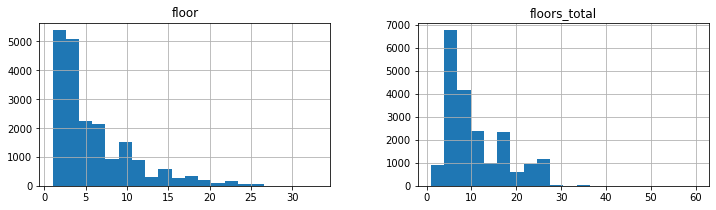

In [21]:
display(data[['floor', 'floors_total']].describe())
display(data.query('floors_total > 40'))
data.hist(figsize=(12, 3), column=[
    'floor',
    'floors_total'
], bins=20);

* Объекты, в основном, продаются на первых восьми этажах. Это объясняется просто: в Санкт-Петербурге не много высоток. Это коррелирует и с этажностью зданий, где видно, что половина не превышает 9 этажей
* По общему количеству этажей есть пара объектов с 52 и 60 этажами. Скорее всего, ошибка - в Санкт-Петербурге нет зданий с такой этажностью. 

##### Расстояние до центра

count    15651.000000
mean     14547.964283
std       8640.027604
min        208.000000
25%       9888.000000
50%      13282.000000
75%      16431.500000
max      65968.000000
Name: city_centers_nearest, dtype: float64


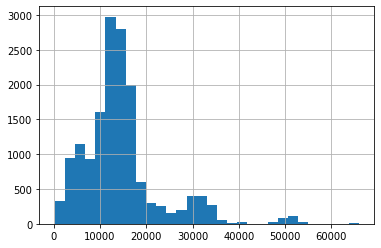

In [22]:
print(data['city_centers_nearest'].describe())
data['city_centers_nearest'].hist(bins=30);

Большая часть объектов продается в пределах между 10 и 16 км от центра. Есть всплески в районе 30 и 50 км - похоже на крупные населенные пункты.

##### Расстояние до аэропорта

count    15651.000000
mean     28884.863395
std      12933.089734
min          0.000000
25%      18373.000000
50%      26803.000000
75%      37434.000000
max      84869.000000
Name: airports_nearest, dtype: float64


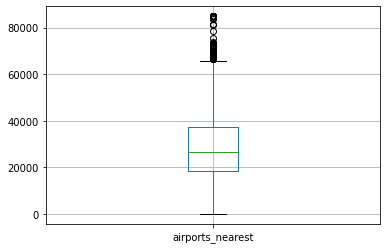

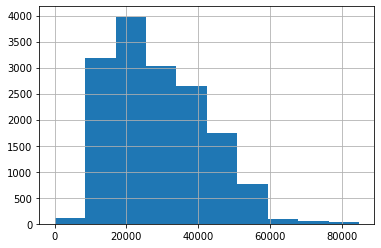

In [23]:
print(data['airports_nearest'].describe())
data.boxplot('airports_nearest');
plt.figure();
data['airports_nearest'].hist();

Небольшое количество аномальных выбросов, начинающихся с 60км от аэропорта. Ничего необычного

##### Расстояние до парков

count    15651.000000
mean      2019.861734
std       1355.748717
min          1.000000
25%        500.500000
50%       3190.000000
75%       3190.000000
max       3190.000000
Name: parks_nearest, dtype: float64


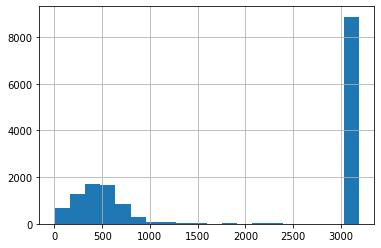

In [24]:
print(data['parks_nearest'].describe())
data['parks_nearest'].hist(bins=20);

Большинство объектов находятся за пределами 3км от парков. В остальном - обычное нормальное распределение. Возможно, здесь была допущена ошибка при предобработке данных - когда было принято решение часть пустых parks_nearest заменить на их максимальное значение. Но без выяснения логики вычисления "nearest" это не возможно сказать наверняка.

##### Дата публикации объявления

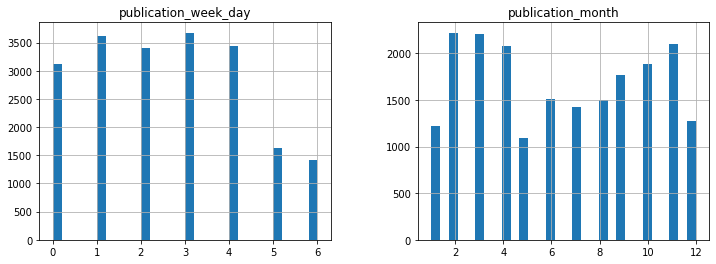

In [25]:
data.hist(figsize=(12, 4), column=[
    'publication_week_day',
    'publication_month'
], bins=30);

* В выходные объявления публикуют реже.
* Весной и осенью объявления публикуют чаще.

##### Типы этажей

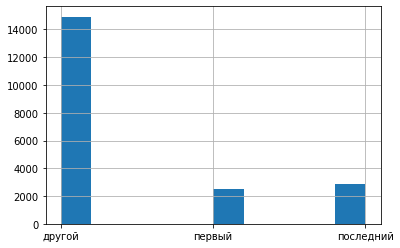

In [26]:
data['floor_kind'].hist();

##### Скорость продажи объектов

count    17584.000000
mean       182.419245
std        218.374044
min          1.000000
25%         44.000000
50%        100.000000
75%        235.000000
max       1580.000000
Name: days_exposition, dtype: float64


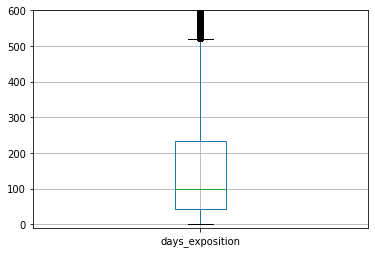

In [27]:
print(data['days_exposition'].describe());

from matplotlib import pyplot as plt
data.boxplot('days_exposition');
plt.ylim(-10, 600);

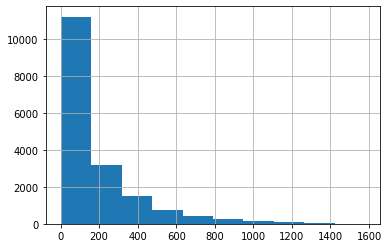

In [28]:
data['days_exposition'].hist();

* Нормой является продажа за 100 дней. 
* К быстрым продажам можно отнести продажи, проходящие за 44 дня, а к долгим - уходящие за 235 дней.
* Кроме того, в наборе данных присутствуют и аномально долгие продажи, занимавшие от 500 дней. Возможно, владельцы объявлений иногда их просто не закрывают. 

#### Факторы, влияющие на полную стоимость объекта

##### Площади

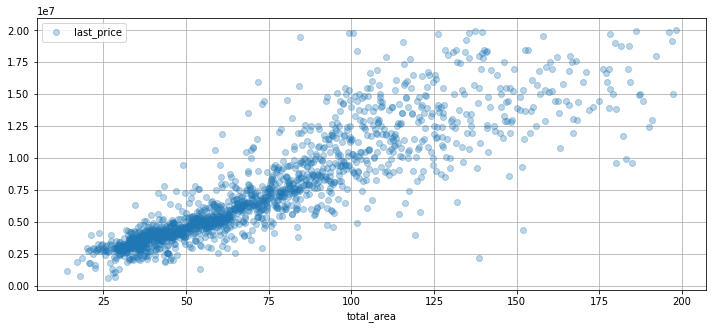

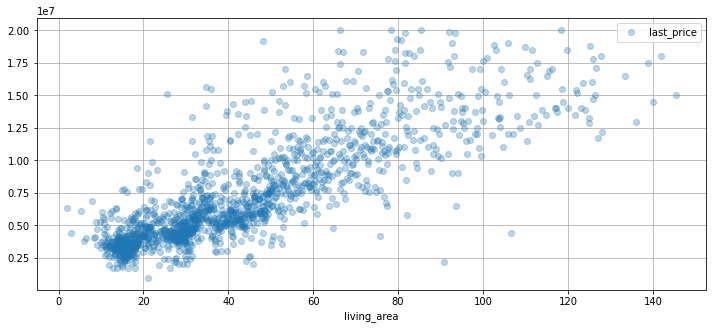

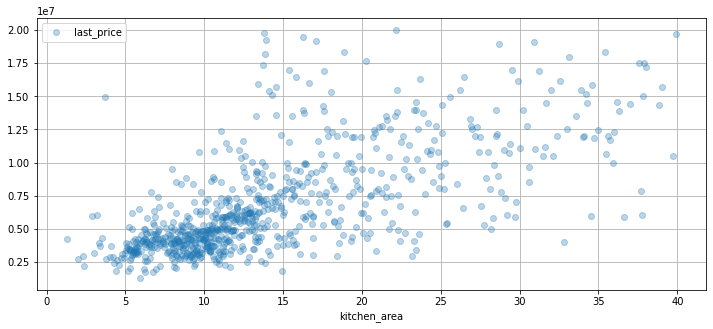

In [29]:
area_columns = ['total_area', 'living_area', 'kitchen_area']
for column in area_columns:
    (data
        .pivot_table(index=column, values='last_price', aggfunc='median')
        .plot(grid=True, figsize=(12, 5), style='o', alpha=0.3)
    );

До определнного значения пощадей цена зависит линейно. Но после этого значения начинается большой разброс - как в сторону удорожания, так и в сторону удешевления. 

Для общей площади эта граница - 100 кв.м., для жилой - 70, а для кухни разброс начинается уже после 15 квадратов.

In [30]:
#подтверждение вывода корелляцией Пирсона:
for column in area_columns:
    print(column + ':', data[column].corr(data['last_price']))

total_area: 0.7713676887475011
living_area: 0.6589233570893217
kitchen_area: 0.5689490986267737


Линейная зависимость позволит использовать данные по площадям для определения рыночной стоимости недвижимости. Но, в любом случае, потребуется учитывать непредсказуемость, начинающуюся с определенных значений площадей.

##### Прочее

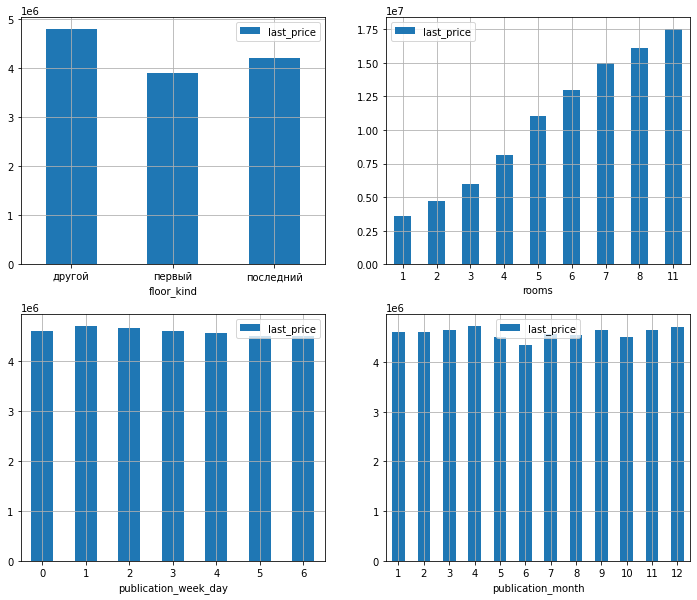

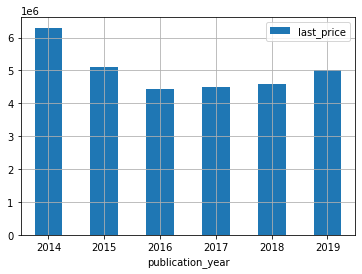

In [31]:
#По этажам, комнатам и датам нагляднее будут столбчатые диаграммы.
#Потому что эти данные разбиваются на четкие категории
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

(data
   .pivot_table(index='floor_kind', values='last_price', aggfunc='median')
   .plot(ax=axs[0,0], grid=True, kind='bar', rot=0)
);
(data
   .pivot_table(index='rooms', values='last_price', aggfunc='median')
   .plot(ax=axs[0,1], grid=True, kind='bar', rot=0)
);
(data
   .pivot_table(index='publication_week_day', values='last_price', aggfunc='median')
   .plot(ax=axs[1,0], grid=True, kind='bar', rot=0)
);
(data
   .pivot_table(index='publication_month', values='last_price', aggfunc='median')
   .plot(ax=axs[1,1], grid=True, kind='bar', rot=0)
);
(data
   .pivot_table(index='publication_year', values='last_price', aggfunc='median')
   .plot(grid=True, kind='bar', rot=0)
);

* Наблюдается небольшая зависимость от этажа. Так, первый этаж - самый дешевый, а самый дорогой - не последний. Но разница между самым дешевым и дорогим - не более 1 млн.
* Есть незначительная зависимость от года публикации - так, объявления от 2014 на 1 млн. дороже объявлений от 2019. Но, скорее всего, это из-за малого количества данных за 2014.
* Самая существенная зависимость цены - от количества комнат. Эта зависимость линейная и вполне логична.

#### Средняя цена квадрата в разрезе населенного пункта

In [32]:
mean_price_per_locality = data.pivot_table(
    index='short_locality_name', 
    values='price_per_meter',
    aggfunc=['count', 'mean']
)
mean_price_per_locality.columns = mean_price_per_locality.columns.droplevel(level = [1])
mean_price_per_locality.sort_values('count', ascending=False).head(10).sort_values('mean')


,count,mean
short_locality_name,,
Выборг,190,58319.351675
Всеволожск,356,67424.113019
Гатчина,290,68635.620745
Колпино,321,75129.845412
Шушары,392,78563.835605
Мурино,458,85750.545681
Парголово,288,90756.003417
Кудрово,378,95349.585996
Пушкин,324,102095.265164


Самое дешевое жильё - в Выборге, а самое дорогое(ожидаемо) - в Санкт-Петербурге. Самое дорогое от самого дешевого отличаются в два раза.

#### Средняя цена километра в Санкт-Петербурге

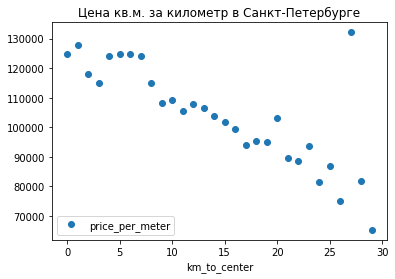

In [33]:
(
    data
    .query('short_locality_name == "Санкт-Петербург"')
    .pivot_table(index='km_to_center', values='price_per_meter', aggfunc='mean')
    .plot(style='o', title = 'Цена кв.м. за километр в Санкт-Петербурге')
);

Тоже вполне ожидаемая линейная зависимость цены от расстояния до центра: от 130000 в центре Санкт-Петербурга до 60000 на окраинах.

### Общий вывод

Перед анализом потребовалось провести большую работу по предобработке. Стоит обратить внимание на возникшие проблемы:
* days_exposition - пустые значения имеют неясный физический смысл. Учитывая, что это поле в системе заполняется автоматически, странно что оно бывает пустым.
* locality_name - в выборке присутствовали неявные дубликаты. Это говорит о том, что в системе либо нет справочника населенных пунктов, либо дубликаты есть в самом справочнике. Кроме того, встречались пустые значения этого поля (возможно, не хватает проверки вводимых данных в ПО)
* картографические данные - значительный объем этой информации оказался не заполнен - похоже на баг в ПО или на ошибку при создании выборки.

Общие выводы:
* Анализ выявил линейную зависимость стоимости недвижимости от площадей недвижимости, от количества комнат и удаленности от центра. 
* Половина продаваемых объектов - небольшие (до 50 кв.м.).
* Большинство объектов продаются в пределах 20км от центра.
* Большая часть недвижимости продается не более чем за 7 млн.
* Потолки, обычно не превышают трех метров.
* Рядом с объектами редко есть парки.
* Объекты, обычно продаются в пределах 200 дней.
* Самое дорогое жильё из выборки - в Санкт-Петербурге.

Для оценки рыночной стоимости больше всего подойдут:
* Общая площадь - по сравнению с жилой и площадью кухни она более предсказуема. Но при площади более 100 кв.м. цена теряет свою предсказуемость.
* Количество комнат - простая линейная зависимость.
* Удаленность от центра (если это Санкт-Петербург) - тоже простая линейная зависимость.
* Населенный пункт.